In [14]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Setup

In [15]:
## Load and filter the data. NMJ (Neuromuscular Junction) connections are not part of the brain network, so we exclude them.
df = pd.read_csv('/Users/simone/Documents/PhD/graph_theory_project/data/NeuronConnect.csv', sep=';')
df_brain = df[df['Type'] != 'NMJ'].copy()

print(f"Original records: {len(df)}")
print(f"Brain network records (excluding NMJ): {len(df_brain)}")
print(f"Edge types found: {df_brain['Type'].unique()}")

Original records: 6417
Brain network records (excluding NMJ): 6264
Edge types found: <StringArray>
['EJ', 'Sp', 'R', 'Rp', 'S']
Length: 5, dtype: str


In [16]:
## Create a directed graph from the brain connectivity data.
G = nx.DiGraph()
for _, row in df_brain.iterrows():
    u = row['Neuron 1']
    v = row['Neuron 2']
    w = row['Nbr'] # Weight (number of connections)
    etype = row['Type']
    
    # Add edge u -> v
    if G.has_edge(u, v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)
    
    # If it is a Gap Junction (EJ), also add v -> u
    if etype == 'EJ':
        if G.has_edge(v, u):
            G[v][u]['weight'] += w
        else:
            G.add_edge(v, u, weight=w)

print(f"Number of Nodes (N): {G.number_of_nodes()}")
print(f"Number of Edges (E): {G.number_of_edges()}")

Number of Nodes (N): 279
Number of Edges (E): 4577


# Fit the distributions focusing on the tail

In-Degree Power Law Exponent (gamma) ~ 1.88


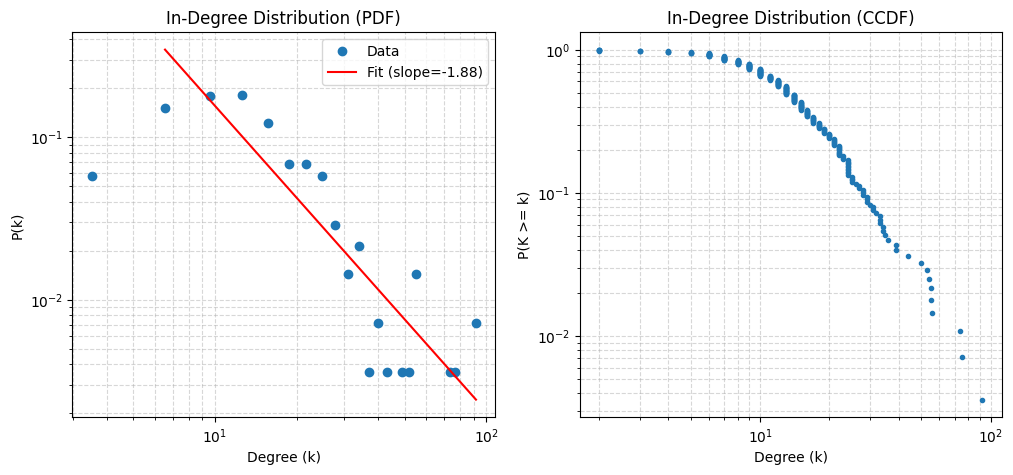

Out-Degree Power Law Exponent (gamma) ~ 1.88


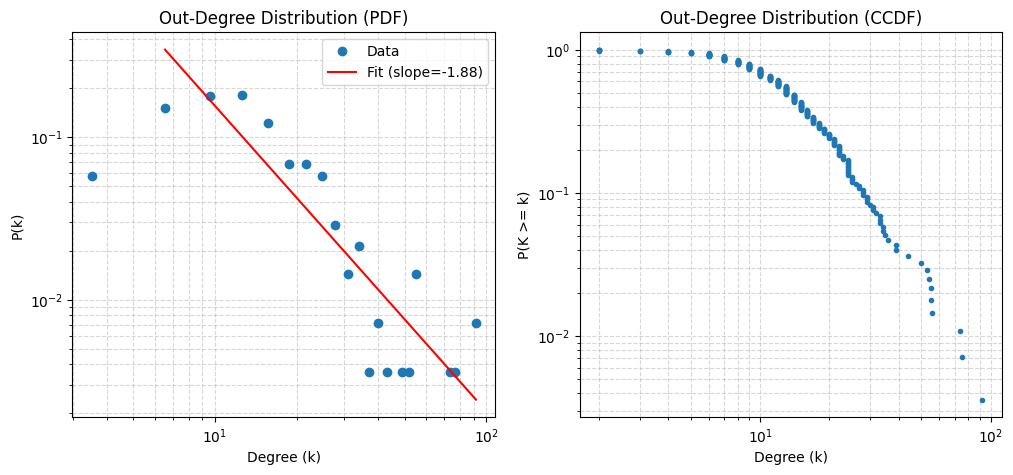

Total Degree Power Law Exponent (gamma) ~ 1.44


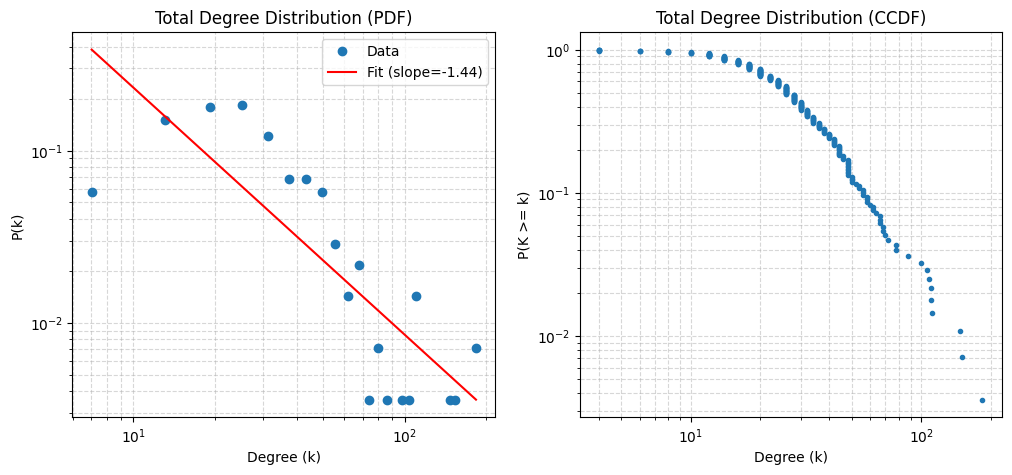

In [17]:
def plot_degree_distribution(G, degree_type='total'):
    """
    Plots the PDF and CCDF of the degree distribution and fits the tail.
    """
    if degree_type == 'in':
        degrees = [d for n, d in G.in_degree()]
        title = "In-Degree"
    elif degree_type == 'out':
        degrees = [d for n, d in G.out_degree()]
        title = "Out-Degree"
    else:
        degrees = [d for n, d in G.degree()]
        title = "Total Degree"
    
    degrees = np.array(degrees)
    degrees = degrees[degrees > 0] # Avoid log(0)
    
    ## Calculate Histogram (PDF)
    counts, bins = np.histogram(degrees, bins=30)
    centers = (bins[:-1] + bins[1:]) / 2
    prob = counts / sum(counts)
    
    ### Plotting
    plt.figure(figsize=(12, 5))
    
    ## PDF Plot
    plt.subplot(1, 2, 1)
    plt.loglog(centers, prob, 'o', label='Data')
    plt.title(f'{title} Distribution (PDF)')
    plt.xlabel('Degree (k)')
    plt.ylabel('P(k)')
    
    #@ Tail Fitting (Power Law estimation)
    # We fit log(P(k)) = -gamma * log(k) + c  -> Linear fit in log-log space
    # We focus on the tail (e.g., k > 10 or k > min_cutoff)
    cutoff = 5 # Visual inspection often needed to choose this
    tail_indices = centers >= cutoff
    if sum(tail_indices) > 2:
        log_k = np.log10(centers[tail_indices])
        # Filter zeros in prob to avoid log(0) errors in fitting
        valid_prob_mask = prob[tail_indices] > 0
        
        if sum(valid_prob_mask) > 2:
            log_prob = np.log10(prob[tail_indices][valid_prob_mask])
            log_k_valid = log_k[valid_prob_mask]
            
            # Linear Regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(log_k_valid, log_prob)
            
            plt.plot(10**log_k_valid, 10**(intercept + slope * log_k_valid), 
                     'r-', label=f'Fit (slope={slope:.2f})')
            print(f"{title} Power Law Exponent (gamma) ~ {-slope:.2f}")

    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)

    # --- CCDF Plot (Often cleaner for power laws) ---
    plt.subplot(1, 2, 2)

    sorted_deg = np.sort(degrees)
    
    # CCDF = 1 - CDF
    y = 1. * np.arange(len(sorted_deg)) / (len(sorted_deg) - 1)
    ccdf = 1 - y 

    plt.loglog(sorted_deg, ccdf, '.', label='Data')
    plt.title(f'{title} Distribution (CCDF)')
    plt.xlabel('Degree (k)')
    plt.ylabel('P(K >= k)')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    plt.show()

# Execute
plot_degree_distribution(G, 'in')
plot_degree_distribution(G, 'out')
plot_degree_distribution(G, 'total')

Graph is strongly connected.
Diameter (LSCC): 20
Average Path Length (LSCC): 3.6112


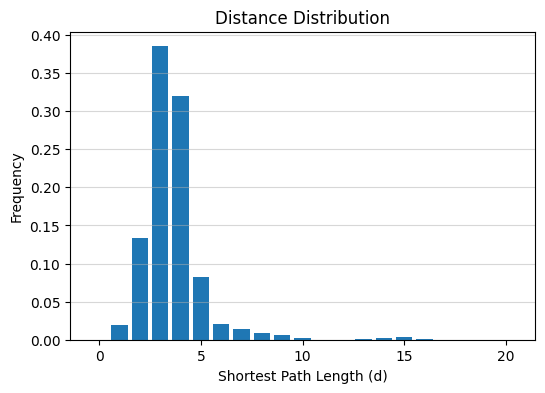

In [18]:
# Use the Largest Strongly Connected Component for robust distance metrics
# (Or Weakly connected if you treat it as undirected for the course's sake)
if nx.is_strongly_connected(G):
    G_sub = G
    print("Graph is strongly connected.")
else:
    # Get largest component
    largest_cc = max(nx.strongly_connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc).copy()
    print(f"Graph not strongly connected. Using LSCC with {G_sub.number_of_nodes()} nodes.")

# Calculate all shortest paths
length_iter = dict(nx.all_pairs_dijkstra_path_length(G_sub))
all_lengths = []
for source, targets in length_iter.items():
    for target, length in targets.items():
        if source != target: # Exclude self-loops distance 0
            all_lengths.append(length)

# Calculate Metrics
diameter = max(all_lengths)
avg_path_len = np.mean(all_lengths)

print(f"Diameter (LSCC): {diameter}")
print(f"Average Path Length (LSCC): {avg_path_len:.4f}")

# Plot Distance Distribution
plt.figure(figsize=(6, 4))
plt.hist(all_lengths, bins=range(0, int(diameter)+2), align='left', rwidth=0.8, density=True)
plt.title("Distance Distribution")
plt.xlabel("Shortest Path Length (d)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.5)
plt.show()

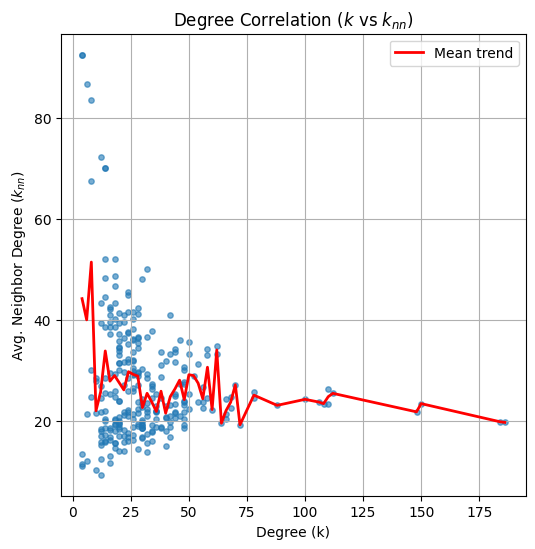

Degree Assortativity Coefficient (r): -0.0923


In [19]:
# Average Nearest Neighbor Degree
knn = nx.average_neighbor_degree(G) # For directed, uses combinations of in/out. 
# You can specify source='in', target='out' etc in nx.average_neighbor_degree if needed.
# Default behaves well for general assortativity check.

k_vals = []
knn_vals = []

for node in G.nodes():
    k = G.degree(node)
    if k > 0 and node in knn:
        k_vals.append(k)
        knn_vals.append(knn[node])

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(k_vals, knn_vals, alpha=0.6, s=15)

# Bin the data to see the trend clearer (Average Knn for each K)
df_corr = pd.DataFrame({'k': k_vals, 'knn': knn_vals})
k_means = df_corr.groupby('k')['knn'].mean()
plt.plot(k_means.index, k_means.values, 'r-', linewidth=2, label='Mean trend')

plt.xlabel('Degree (k)')
plt.ylabel('Avg. Neighbor Degree ($k_{nn}$)')
plt.title('Degree Correlation ($k$ vs $k_{nn}$)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Pearson Correlation Coefficient (r)
r = nx.degree_pearson_correlation_coefficient(G)
print(f"Degree Assortativity Coefficient (r): {r:.4f}")

In [20]:
# Global Clustering Coefficient (Transitivity)
C_global = nx.transitivity(G)

# Average Local Clustering Coefficient
C_avg = nx.average_clustering(G) 

print(f"Global Clustering (Transitivity): {C_global:.4f}")
print(f"Average Clustering Coefficient: {C_avg:.4f}")

Global Clustering (Transitivity): 0.2135
Average Clustering Coefficient: 0.3371


# Null model analysis

In [21]:
n_realizations = 100
N = G.number_of_nodes()
E = G.number_of_edges()

rand_C = []
rand_L = []

print(f"Generating {n_realizations} ER random graphs...")

for i in range(n_realizations):
    # Generate ER graph with same N and same number of edges E
    # G(N, L) model
    ER = nx.gnm_random_graph(N, E, directed=True)
    
    # Calculate Clustering
    rand_C.append(nx.average_clustering(ER))
    
    # Calculate Path Length on Largest Component to be safe
    if nx.is_strongly_connected(ER):
        rand_L.append(nx.average_shortest_path_length(ER))
    else:
        largest_cc_er = max(nx.strongly_connected_components(ER), key=len)
        sub_er = ER.subgraph(largest_cc_er)
        if len(sub_er) > 1:
            rand_L.append(nx.average_shortest_path_length(sub_er))

## Statistics
mu_C = np.mean(rand_C)
std_C = np.std(rand_C)
mu_L = np.mean(rand_L)
std_L = np.std(rand_L)

print("-" * 30)
print(f"Empirical C: {C_avg:.4f} | Random C (mean): {mu_C:.4f} (std: {std_C:.4f})")
print(f"Empirical L: {avg_path_len:.4f} | Random L (mean): {mu_L:.4f} (std: {std_L:.4f})")
print("-" * 30)

# Z-Scores (Significance)
z_score_C = (C_avg - mu_C) / std_C
z_score_L = (avg_path_len - mu_L) / std_L

print(f"Z-score Clustering: {z_score_C:.2f}")
print(f"Z-score Path Length: {z_score_L:.2f}")

if C_avg > mu_C and abs(z_score_L) < 10: # Heuristic check
    print("\nConclusion: The network exhibits Small-World properties (High C, Low L).")

Generating 100 ER random graphs...
------------------------------
Empirical C: 0.3371 | Random C (mean): 0.0590 (std: 0.0007)
Empirical L: 3.6112 | Random L (mean): 2.2992 (std: 0.0022)
------------------------------
Z-score Clustering: 398.25
Z-score Path Length: 588.91


# Community detection

In [22]:
# Note: Louvain usually requires an undirected graph. 
# Convert to undirected for community detection purposes.
G_undirected = G.to_undirected()

try:
    from networkx.algorithms.community import louvain_communities
    
    communities = louvain_communities(G_undirected, seed=42)
    print(f"\nDetected {len(communities)} communities.")
    
    # Calculate Modularity
    modularity = nx.community.modularity(G_undirected, communities)
    print(f"Modularity (Q): {modularity:.4f}")
    
    # Visualize top 3 largest communities
    communities = sorted(communities, key=len, reverse=True)
    print("Largest community sizes:", [len(c) for c in communities[:5]])

except ImportError:
    print("Louvain algorithm not available in this networkx version. Try 'pip install networkx' upgrade.")


Detected 7 communities.
Modularity (Q): 0.5061
Largest community sizes: [84, 73, 51, 31, 17]


/var/folders/3p/shj2kb9x3jjdx507cm6pndgc0000gn/T/ipykernel_37401/3654425644.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(communities))


Community structure plot saved to community_structure.png


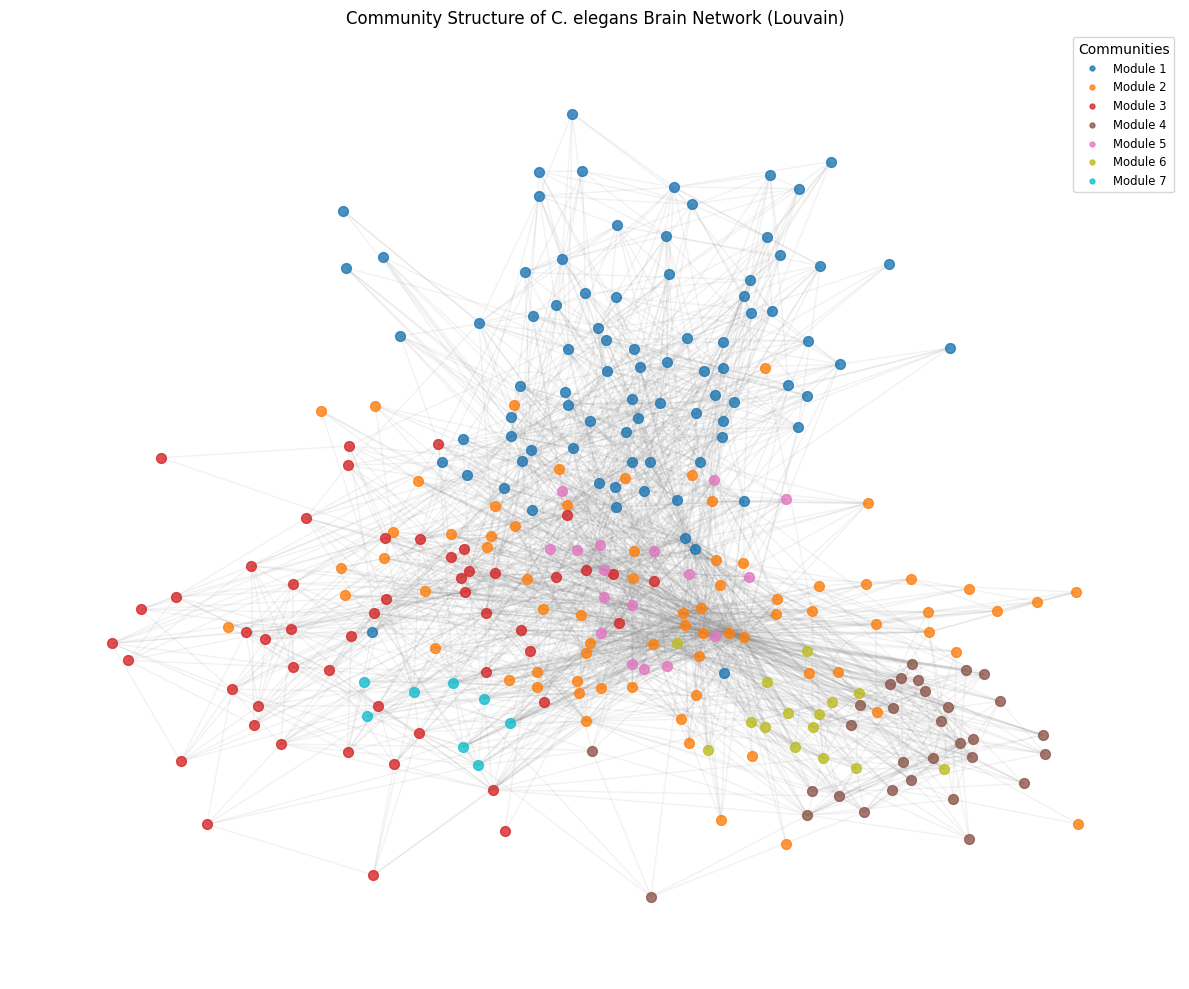

In [ ]:
import matplotlib.cm as cm

def plot_community_structure(G, communities, filename="community_structure.png"):
    """
    Visualizes the network with nodes colored by their community.
    """
    # 1. Create a map of node -> community index
    partition = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            partition[node] = idx
            
    # 2. Setup the plot
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42, k=0.15)  # k regulates the distance between nodes
    
    # 3. Color nodes based on community
    # Get distinct colors from a colormap (e.g., 'tab10', 'viridis', 'jet')
    cmap = cm.get_cmap('tab10', len(communities))
    
    # Draw nodes
    for idx, comm in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), 
                               node_size=50, 
                               node_color=[cmap(idx)], 
                               alpha=0.8,
                               label=f"Module {idx+1}")
                               
    # 4. Draw edges (lighter and thinner to avoid clutter)
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')

    plt.title("Community Structure of C. elegans Brain Network (Louvain)")
    plt.axis('off')
    
    # Create a legend for the largest communities
    plt.legend(loc='upper right', title="Communities", fontsize='small', markerscale=0.5)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"Community structure plot saved to {filename}")
    plt.show()

# Run the visualization
# Note: Use G_undirected for the layout calculation as well, usually looks better for communities
plot_community_structure(G_undirected, communities)